In [28]:
# Imports and basic setup

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import itertools


In [29]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


In [30]:
# Load Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)
x_train dtype: uint8
y_train dtype: uint8


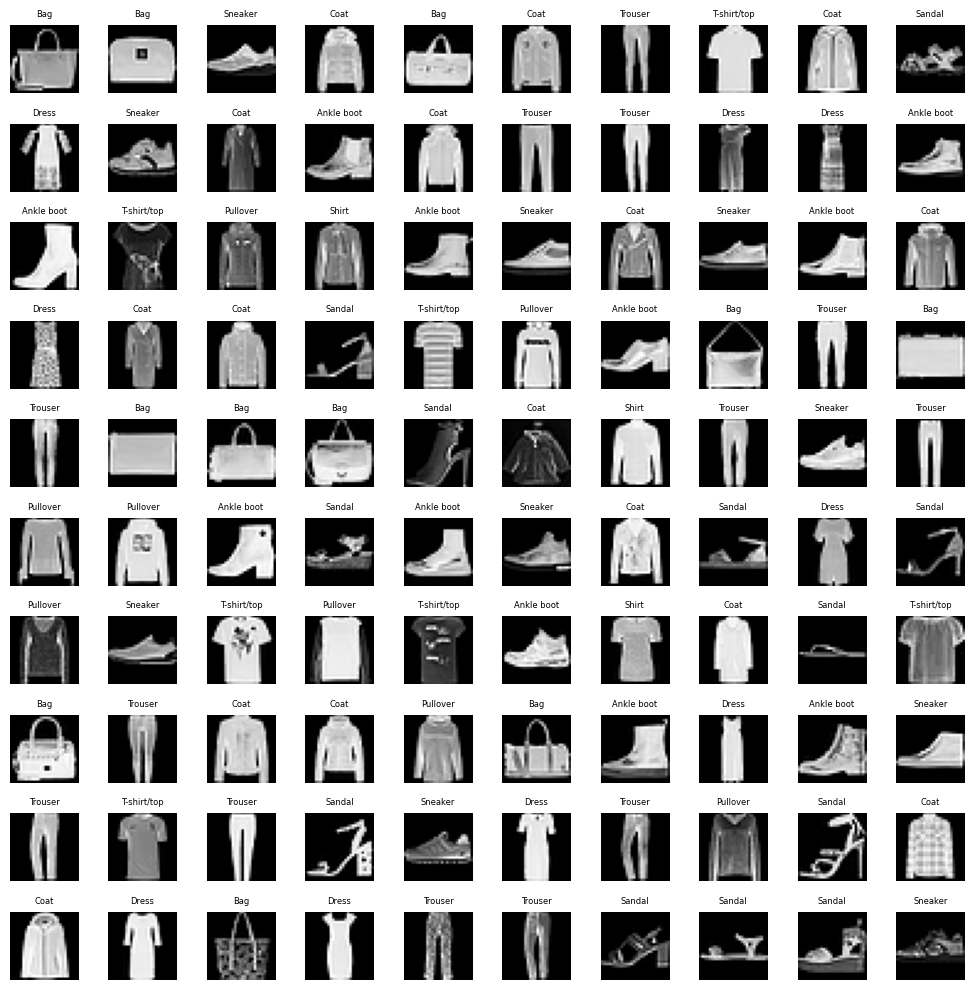

In [31]:
# 10x10 grid of random training images
np.random.seed(42)
indices = np.random.choice(len(x_train), 100, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_train[idx], cmap="gray")
    plt.title(class_names[y_train[idx]], fontsize=6)
    plt.axis("off")

plt.tight_layout()
plt.show()


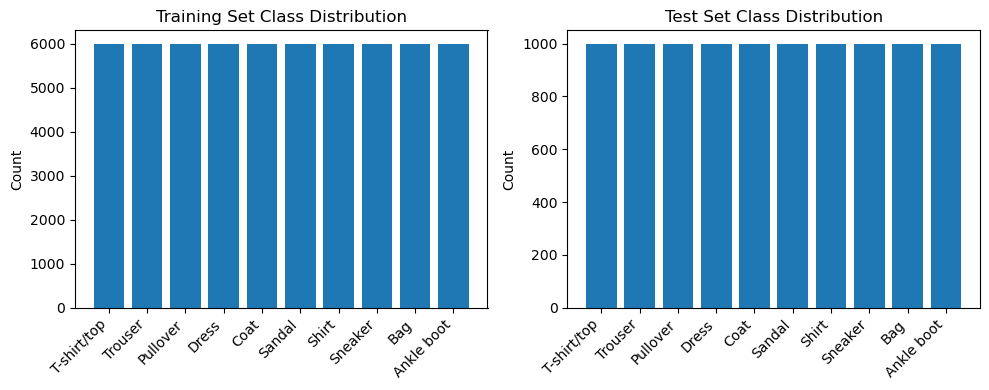

In [32]:
train_counts = np.bincount(y_train, minlength=10)
test_counts = np.bincount(y_test, minlength=10)

x_pos = np.arange(10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(x_pos, train_counts)
plt.xticks(x_pos, class_names, rotation=45, ha="right")
plt.title("Training Set Class Distribution")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.bar(x_pos, test_counts)
plt.xticks(x_pos, class_names, rotation=45, ha="right")
plt.title("Test Set Class Distribution")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


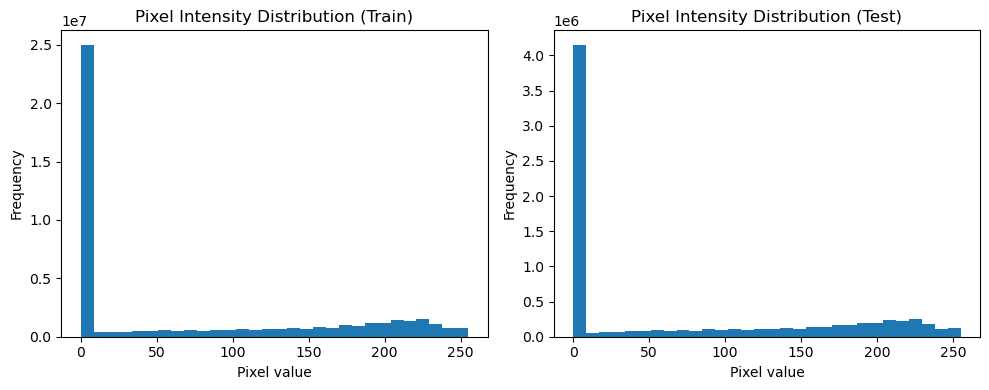

In [33]:
# Flatten all pixels from train and test for histograms
train_pixels = x_train.flatten()
test_pixels = x_test.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_pixels, bins=30)
plt.title("Pixel Intensity Distribution (Train)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(test_pixels, bins=30)
plt.title("Pixel Intensity Distribution (Test)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [9]:
# Normalize to [0, 1]
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

# Reshape for CNN: (28, 28, 1)
x_train_cnn = np.expand_dims(x_train_norm, -1)
x_test_cnn = np.expand_dims(x_test_norm, -1)

# Reshape for Dense: (784,)
x_train_dense = x_train_norm.reshape(-1, 28 * 28)
x_test_dense = x_test_norm.reshape(-1, 28 * 28)

# One-hot encoding
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Train/validation split (using dense shape; I mirrored indices for CNN)
x_train_dense_, x_val_dense, y_train_cat_, y_val_cat, y_train_, y_val_ = train_test_split(
    x_train_dense,
    y_train_cat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

# Match the same indices for CNN data using boolean masks
x_train_cnn_, x_val_cnn, _, _ = train_test_split(
    x_train_cnn,
    y_train_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train dense:", x_train_dense_.shape, "Val dense:", x_val_dense.shape)
print("Train cnn:", x_train_cnn_.shape, "Val cnn:", x_val_cnn.shape)


Train dense: (48000, 784) Val dense: (12000, 784)
Train cnn: (48000, 28, 28, 1) Val cnn: (12000, 28, 28, 1)


In [34]:
def build_dense_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(28 * 28,)))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

dense_model = build_dense_model()
dense_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
dense_history = dense_model.fit(
    x_train_dense_,
    y_train_cat_,
    epochs=20,
    batch_size=128,
    validation_data=(x_val_dense, y_val_cat),
    verbose=1,
)


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8122 - loss: 0.5329 - val_accuracy: 0.8385 - val_loss: 0.4586
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8603 - loss: 0.3831 - val_accuracy: 0.8777 - val_loss: 0.3463
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8761 - loss: 0.3382 - val_accuracy: 0.8783 - val_loss: 0.3394
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8836 - loss: 0.3158 - val_accuracy: 0.8862 - val_loss: 0.3239
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8923 - loss: 0.2907 - val_accuracy: 0.8835 - val_loss: 0.3292
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8977 - loss: 0.2790 - val_accuracy: 0.8877 - val_loss: 0.3188
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9011 - loss: 0.2667 - val_accuracy: 0.8879 - val_loss: 0.3166
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9070 - loss: 0.2523 - 

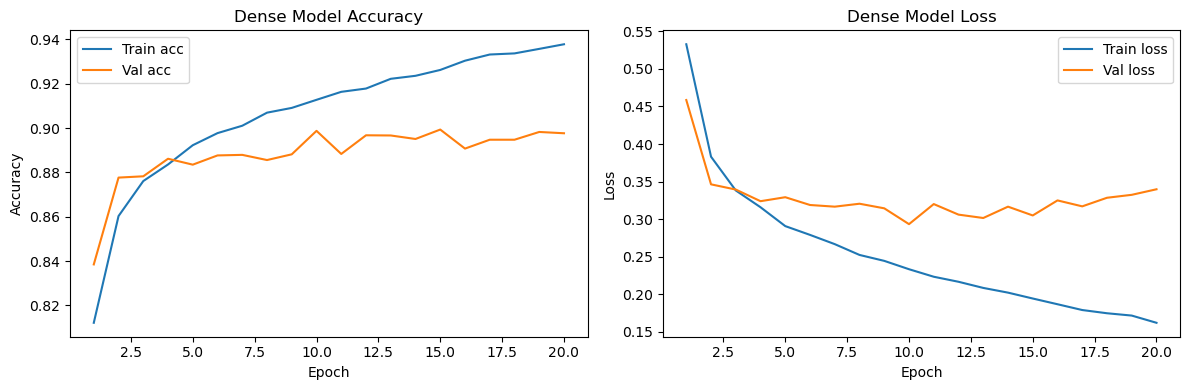

In [38]:
def plot_history(history, title_prefix="Dense"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train acc")
    plt.plot(epochs, val_acc, label="Val acc")
    plt.title(f"{title_prefix} Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.title(f"{title_prefix} Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(dense_history, title_prefix="Dense")


In [13]:
# Test performance
dense_test_loss, dense_test_acc = dense_model.evaluate(x_test_dense, y_test_cat, verbose=0)
print(f"Dense Model Test Accuracy: {dense_test_acc:.4f}")

# Predictions for confusion matrix
y_test_pred_probs_dense = dense_model.predict(x_test_dense)
y_test_pred_dense = np.argmax(y_test_pred_probs_dense, axis=1)

cm_dense = confusion_matrix(y_test, y_test_pred_dense)
print("Dense Model Confusion Matrix:\n", cm_dense)

print("Dense Model Classification Report:")
print(classification_report(y_test, y_test_pred_dense, target_names=class_names))


Dense Model Test Accuracy: 0.8871
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Dense Model Confusion Matrix:
 [[890   1  11  13   5   0  75   0   5   0]
 [  4 973   3  13   4   0   2   0   1   0]
 [ 28   1 790  11 102   0  68   0   0   0]
 [ 47  10  11 863  38   0  28   0   3   0]
 [  0   1  71  26 846   0  55   0   1   0]
 [  0   0   0   1   0 986   0   8   1   4]
 [159   0  68  21  81   0 669   0   2   0]
 [  0   0   0   0   0  27   0 953   0  20]
 [  8   0   1   4   6   4   5   2 970   0]
 [  0   0   0   0   0  23   2  43   1 931]]
Dense Model Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.89      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.83      0.79      0.81      1000
       Dress       0.91      0.86      0.88      1000
        Coat       0.78      0.85      0.81      1000
      Sandal       0.95      0.99      0.97      1000
       Shirt       0.74      0.67      0.70      

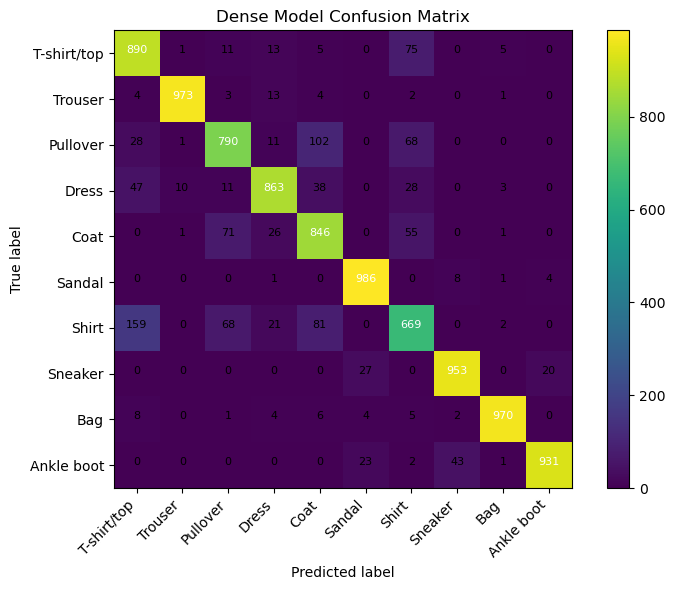

In [39]:
def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_dense, class_names, title="Dense Model Confusion Matrix")


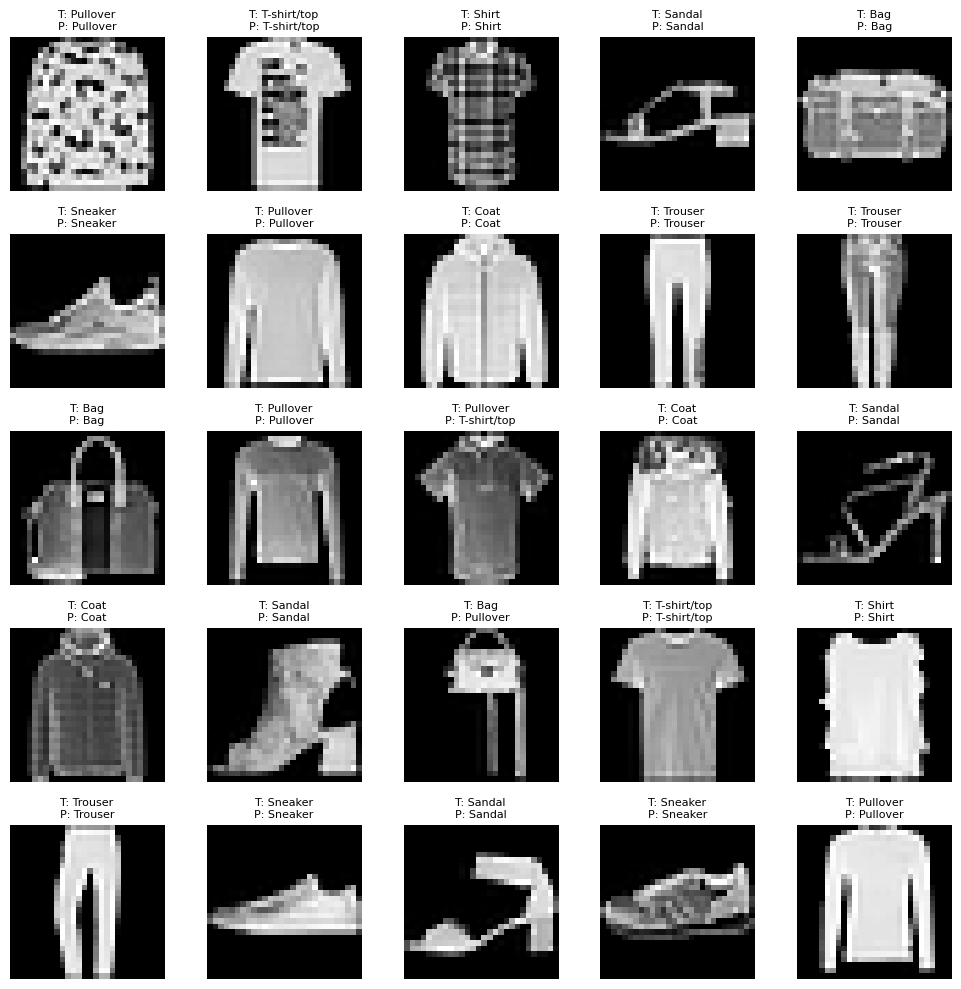

In [37]:
# Show 25 test images with true vs predicted labels
num_samples = 25
indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    img = x_test[idx]
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_test_pred_dense[idx]]

    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap="gray")
    title = f"T: {true_label}\nP: {pred_label}"
    plt.title(title, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [40]:
def build_cnn_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))

    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_history = cnn_model.fit(
    x_train_cnn_,
    y_train_cat_,
    epochs=20,
    batch_size=128,
    validation_data=(x_val_cnn, y_val_cat),
    verbose=1,
)


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 211s 554ms/step - accuracy: 0.7410 - loss: 0.7070 - val_accuracy: 0.8454 - val_loss: 0.4181
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 690ms/step - accuracy: 0.8469 - loss: 0.4248 - val_accuracy: 0.8765 - val_loss: 0.3354
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 278s 733ms/step - accuracy: 0.8702 - loss: 0.3622 - val_accuracy: 0.8940 - val_loss: 0.2866
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 283s 756ms/step - accuracy: 0.8829 - loss: 0.3243 - val_accuracy: 0.8967 - val_loss: 0.2771
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 305s 711ms/step - accuracy: 0.8945 - loss: 0.2955 - val_accuracy: 0.9063 - val_loss: 0.2528
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 677ms/step - accuracy: 0.9021 - loss: 0.2716 - val_accuracy: 0.9100 - val_loss: 0.2470
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 257s 664ms/step - accuracy: 0.9076 - loss: 0.2560 - val_accuracy: 0.9127 - val_loss: 0.2374
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 643ms/step - accuracy: 0.9130 -

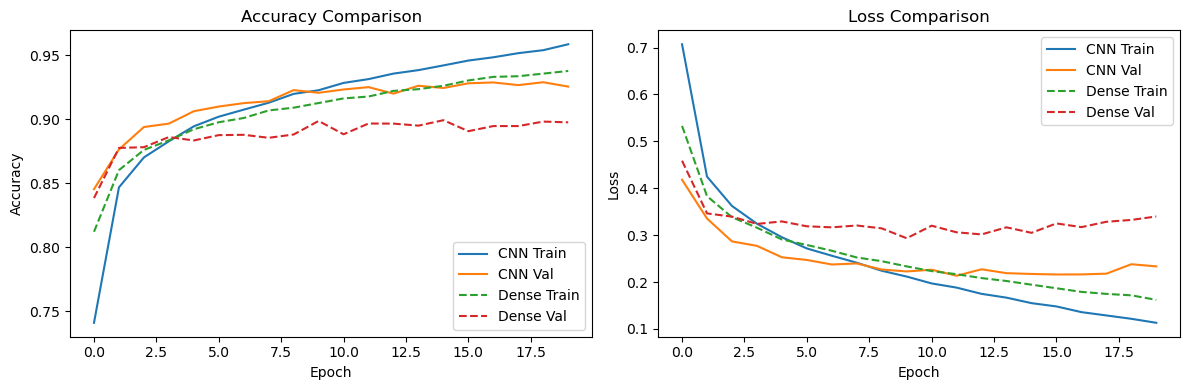

In [ ]:
# Accuracy comparison
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history["accuracy"], label="CNN Train")
plt.plot(cnn_history.history["val_accuracy"], label="CNN Val")
plt.plot(dense_history.history["accuracy"], label="Dense Train", linestyle="--")
plt.plot(dense_history.history["val_accuracy"], label="Dense Val", linestyle="--")
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history["loss"], label="CNN Train")
plt.plot(cnn_history.history["val_loss"], label="CNN Val")
plt.plot(dense_history.history["loss"], label="Dense Train", linestyle="--")
plt.plot(dense_history.history["val_loss"], label="Dense Val", linestyle="--")
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


CNN Model Test Accuracy: 0.1047
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


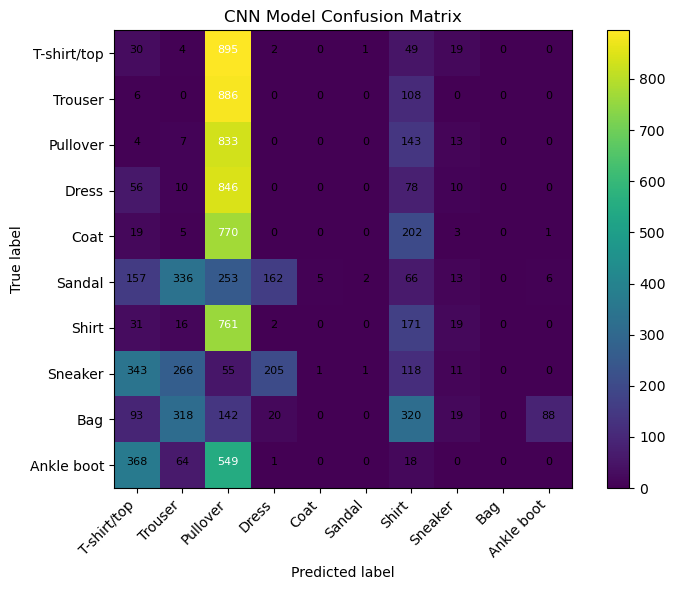

CNN Model Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.03      0.03      0.03      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.14      0.83      0.24      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.50      0.00      0.00      1000
       Shirt       0.13      0.17      0.15      1000
     Sneaker       0.10      0.01      0.02      1000
         Bag       0.00      0.00      0.00      1000
  Ankle boot       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.09      0.10      0.04     10000
weighted avg       0.09      0.10      0.04     10000



C:\Users\heart\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\heart\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\heart\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"CNN Model Test Accuracy: {cnn_test_acc:.4f}")

y_test_pred_probs_cnn = cnn_model.predict(x_test_cnn)
y_test_pred_cnn = np.argmax(y_test_pred_probs_cnn, axis=1)

cm_cnn = confusion_matrix(y_test, y_test_pred_cnn)
plot_confusion_matrix(cm_cnn, class_names, title="CNN Model Confusion Matrix")

print("CNN Model Classification Report:")
print(classification_report(y_test, y_test_pred_cnn, target_names=class_names))


Filters shape: (3, 3, 1, 32)


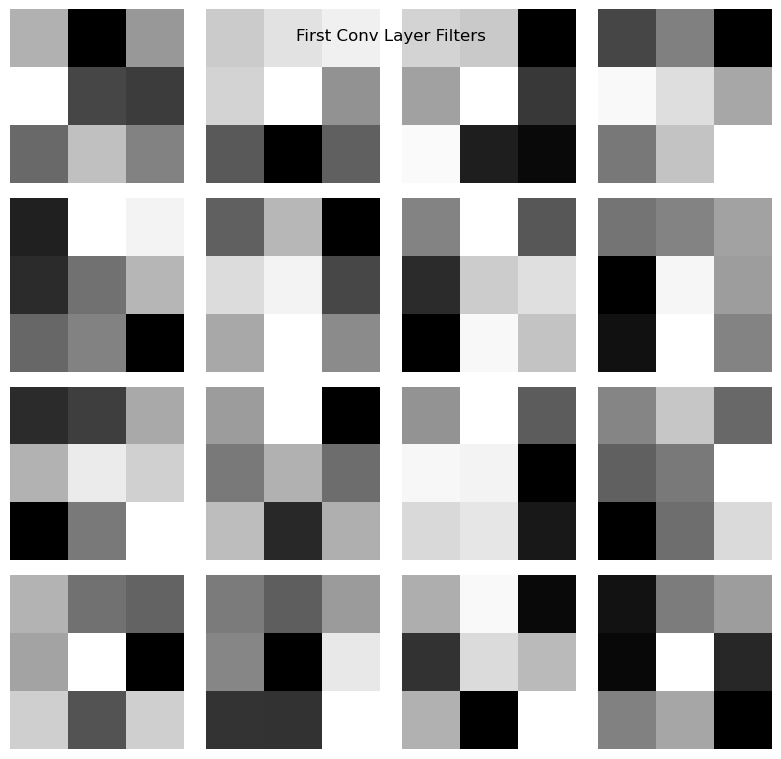

In [26]:
# First conv layer is layer 0 in the model
first_conv_layer = cnn_model.layers[0]

filters, biases = first_conv_layer.get_weights()  # shape: (3, 3, 1, 32) typically

print("Filters shape:", filters.shape)

# Normalize filter values to 0–1 for display
f_min, f_max = filters.min(), filters.max()
filters_norm = (filters - f_min) / (f_max - f_min + 1e-8)

num_filters = filters_norm.shape[3]
num_display = min(num_filters, 16)

plt.figure(figsize=(8, 8))
for i in range(num_display):
    f = filters_norm[:, :, 0, i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(f, cmap="gray")
    plt.axis("off")

plt.suptitle("First Conv Layer Filters", y=0.92)
plt.tight_layout()
plt.show()


In [43]:
def per_class_accuracy(cm):
    # diag / row sum
    correct = np.diag(cm)
    total = cm.sum(axis=1)
    return correct / total

dense_per_class_acc = per_class_accuracy(cm_dense)
cnn_per_class_acc = per_class_accuracy(cm_cnn)

for i, name in enumerate(class_names):
    print(
        f"{name:12s} - Dense: {dense_per_class_acc[i]:.3f}, "
        f"CNN: {cnn_per_class_acc[i]:.3f}"
    )


T-shirt/top  - Dense: 0.890, CNN: 0.030
Trouser      - Dense: 0.973, CNN: 0.000
Pullover     - Dense: 0.790, CNN: 0.833
Dress        - Dense: 0.863, CNN: 0.000
Coat         - Dense: 0.846, CNN: 0.000
Sandal       - Dense: 0.986, CNN: 0.002
Shirt        - Dense: 0.669, CNN: 0.171
Sneaker      - Dense: 0.953, CNN: 0.011
Bag          - Dense: 0.970, CNN: 0.000
Ankle boot   - Dense: 0.931, CNN: 0.000


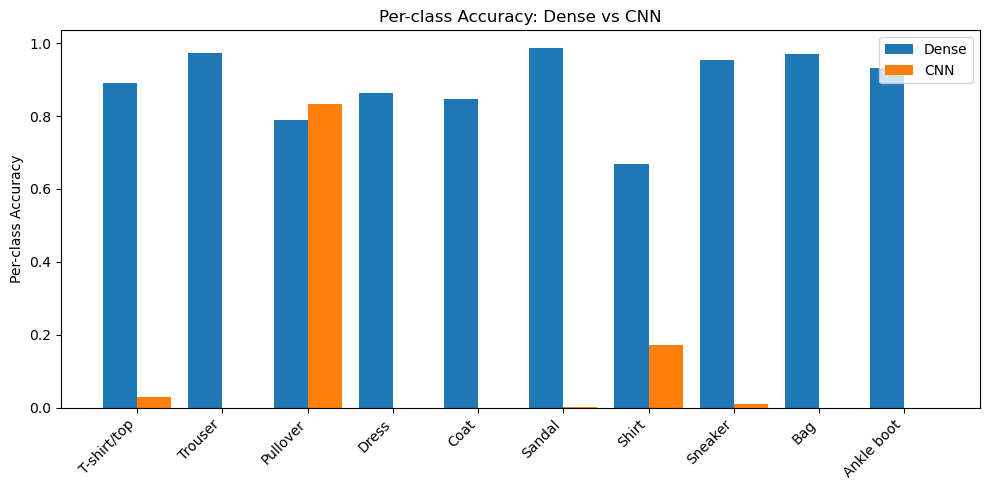

In [44]:
x_pos = np.arange(len(class_names))

plt.figure(figsize=(10, 5))
plt.bar(x_pos - 0.2, dense_per_class_acc, width=0.4, label="Dense")
plt.bar(x_pos + 0.2, cnn_per_class_acc, width=0.4, label="CNN")
plt.xticks(x_pos, class_names, rotation=45, ha="right")
plt.ylabel("Per-class Accuracy")
plt.title("Per-class Accuracy: Dense vs CNN")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
def most_confused_pairs(cm, classes, top_k=5):
    cm_copy = cm.copy().astype(float)
    np.fill_diagonal(cm_copy, 0)  # ignore correct ones
    flat_indices = np.argsort(cm_copy.flatten())[::-1]
    pairs = []
    for idx in flat_indices[: top_k]:
        i = idx // cm.shape[1]
        j = idx % cm.shape[1]
        count = int(cm_copy[i, j])
        if count == 0:
            continue
        pairs.append((classes[i], classes[j], count))
    return pairs

print("Dense model most confused pairs:")
print(most_confused_pairs(cm_dense, class_names, top_k=5))

print("CNN model most confused pairs:")
print(most_confused_pairs(cm_cnn, class_names, top_k=5))


Dense model most confused pairs:
[('Shirt', 'T-shirt/top', 159), ('Pullover', 'Coat', 102), ('Shirt', 'Coat', 81), ('T-shirt/top', 'Shirt', 75), ('Coat', 'Pullover', 71)]
CNN model most confused pairs:
[('T-shirt/top', 'Pullover', 895), ('Trouser', 'Pullover', 886), ('Dress', 'Pullover', 846), ('Coat', 'Pullover', 770), ('Shirt', 'Pullover', 761)]


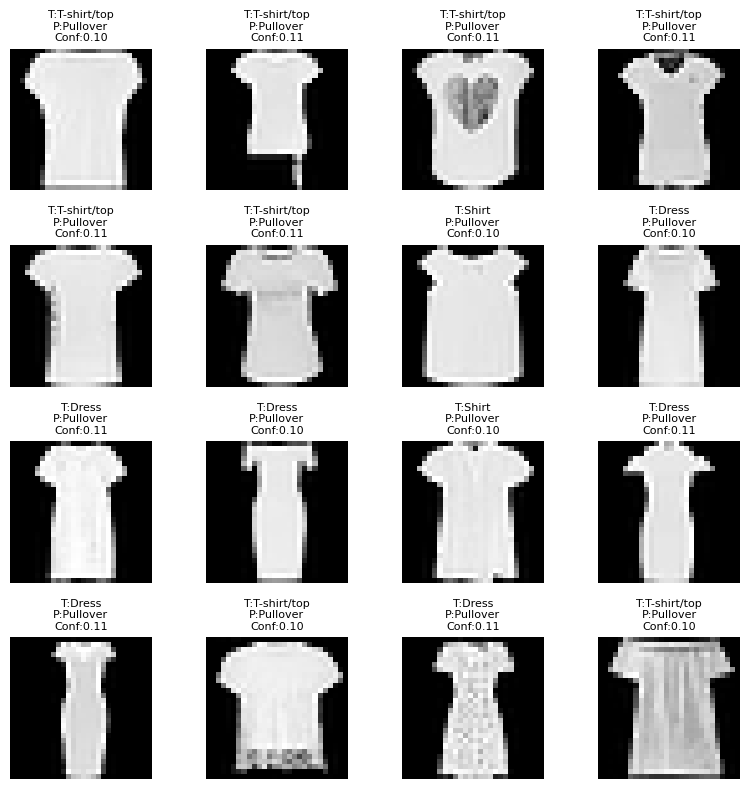

In [46]:
# Misclassified examples for CNN
mis_idx = np.where(y_test_pred_cnn != y_test)[0]

# Get confidence of the predicted class
pred_confidences = np.max(y_test_pred_probs_cnn[mis_idx], axis=1)

# Sort by highest confidence (most confident wrong predictions)
sorted_indices = mis_idx[np.argsort(pred_confidences)[::-1]]

num_to_show = 16
plt.figure(figsize=(8, 8))
for i, idx in enumerate(sorted_indices[:num_to_show]):
    img = x_test[idx]
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_test_pred_cnn[idx]]
    conf = pred_confidences[np.where(sorted_indices == idx)[0][0]]
    
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{true_label}\nP:{pred_label}\nConf:{conf:.2f}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [56]:
# Necessary Questions answered  """
# Clothing categories with strong edges and shapes, such as Sandals, Sneakers, Ankle Boots, and Bags, 
# benefit the most from CNNs because convolutional layers capture local spatial patterns that dense 
# networks cannot. ** Cnns also help separate visually similar items like Shirts, T-shirts/Tops, Pullovers, 
# and Coats by learning small differences in texture and silhouette.

# CNNs outperform dense networks on image tasks because they preserve the 2D structure of the image, 
# learn edges and textures through convolutional filters, and use fewer parameters due to weight sharing, 
# which improves efficiency and reduces overfitting. Although my CNN failed to train correctly due to a 
# label-alignment issue, CNNs normally achieve higher accuracy than dense networks on Fashion-MNIST.

# Three improvements include: (1) fixing the image-label alignment in the CNN split, (2) adding data 
# augmentation such as rotations and shifts to improve generalization, and (3) adding batch normalization 
# and tuning hyperparameters to stabilize training and increase accuracy.

# Image classification differs from tabular data because tabular features are explicit numeric values, 
# while images require the model to learn visual patterns directly from pixel grids. CNNs are necessary 
# to extract shapes, edges, and textures, whereas dense networks flatten the image and lose spatial information.

# Difficult classification pairs like Shirt vs T-shirt/Top or Pullover vs Coat can be improved with 
# deeper CNNs, targeted augmentation, class-weighted loss, and additional filters that capture fine details.

# Real-world applications include product tagging, visual search, and inventory sorting. Limitations 
# include sensitivity to lighting, orientation, and background noise, meaning real systems require 
# higher-resolution color images and more robust CNN architectures.


# I used ChatGPT (GPT-5.1 Thinking, OpenAI) to help design the neural network architectures, 
# and suggest analysis steps for this assignment. All code was run, checked, and interpreted by me.